# Lição 5 - Deep Deterministic Policy Gradient (DDPG)

## 1. Introdução <a class="anchor" name="section_1"></a>



Na última lição, introduzimos a *Deep Q-Network* (DQN), a primeira estrutura do DRL, que mesclava conceitos de RL e conceitos DL. Nós mostramos que é possível encontrar uma política capaz de solucionar o problema do *cartople*, um problema complexo para os algoritmos de outras áreas. Entretanto, depois de 2013, ano de criação do DQN, vários outros algoritmos de DRL foram criados para solucionar algumas limitações que a estrutura pioneira apresentava. Nesse sentido surge o *Deep Deterministic Policy Gradient* (DDPG), um algoritmo clássico que nos fornece flexibilidade para trabalhar tanto com ações discretas (como o DQN), como com ações contínuas.

### 1.1 Índice <a class="anchor" name="section_1.1"></a>

* [1. Introdução](#section_1)
    * [1.1 Índice](#section_1.1)
* [2. O problema do Pêndulo](#section_2)
* [3. Redes do tipo Actor-Critic](#section_3)
    * [3.1 Deep Deterministic Gradient Policy - DDPG](#section_3.1)
    * [3.2 Estratégias de treinamento do DDPG](#section_3.2)
        * [3.2.1 Ruído nos parâmetros para exploração](#section_3.2.1)
* [4. Implementação do algoritmo](#section_4)
* [5. Sugestões](#section_5)
* [6. Referências](#section_6)

Iniciaremos o problema importando as bibliotecas que usaremos ao longo da nossa implementação.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import gym

Antes de iniciarmos a implementação do código de fato, vamos verificar se há alguma GPU disponível para rodar os códigos, com o intuito de tornar mais rápido o treinamento do modelo.

In [2]:
def testar_gpu():
    '''
    Função que testa se a GPU está habilitada.
    
    Outputs:
    --------
    device: {str}
        variável que define se o código será executado na CPU ou na GPU
    '''
    train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
    if train_on_gpu: #Se sim
        device = torch.device('cuda') #Seleciona o device como GPU
        print("Treinando na GPU") #E manda a mensagem
    else: #Se não
        device = torch.device('cpu') #Seleciona o device como cpu
        print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
    
    return device

#Coleta onde o ambiente será executado
device = testar_gpu()

Treinando na GPU


Como apresentado na última lição, implementaremos a definição de transição de um ambiente DRL, com estado, ação, próximo estado e recompensa.

In [3]:
#Define uma transição como um tupla com estado, ação, próximo estado e recompensa.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

## 2. O problema do Pêndulo <a class="anchor" name="section_2"></a>

A última lição mostrou uma implementação de uma *Deep Q-Network*, a rede mais básica de DRL, que nos permitiu elaborar um algoritmo que conseguisse decidir quais ações devem ser tomadas pelo *cartpole*, para evitar que a haste caia. 

Entretanto, esse algoritmo apresenta uma clara limitação: ela só consegue resolver problemas em que as ações possíveis são **discretas**. Isso é perceptível ao perceber que a rede retorna apenas **qual** ação deve ser tomada, e não **como** ela deve ser executada. Passemos a um outro problema para que isso fique mais claro.

Pense em um jogo parecido com o *cartpole*, mas agora nós queremos equilibrar um pêndulo verticalmente na posição mais alta possível. Para isso, nós podemos aplicar forças no pêndulo tanto no sentido horário como no anti-horário, tal que a intensidade dessa força é um valor contínuo, de forma que a rotação pode ter mais ou menos intensidade, a depender da força aplicada.

Assim, a rotação do pêndulo é controlada por um agente que define uma ação tal que $-2 < a < 2$, em que os valores negativos indicam que as forças são no sentido anti-horário e os positivos que são no sentido horário, enquanto o módulo do ação tal que $|a|<2$, indica a intensidade da força aplicada. A imagem abaixo mostra o pêndulo em vermelho e a representação da força aplicada como a seta preta.

<center>
<img src="imagens/pendulum.PNG"></img>
</center>
Figura 1 - Pêndulo e força aplicada.

Repare que a ação desse ambiente é **contínua**, isto é, não basta o agente saber que precisa aplicar uma força em um ou outro sentido, ele precisa entender **o quanto** de intensidade ele deve colocar na força que será aplicada.

Voltemos, então, ao DQL. Para implementar uma DQN, neste caso, precisaríamos discretizar a intensidade da força e combiná-las com o sentido de rotação, considerando que cada uma dessas combinações seja uma ação possível com um $Q(s,a)$ calculável. 

Perceba que essa não é uma abordagem eficaz mesmo para um problema relativamente simples como esse. Identificando essa limitação, desenvolveu-se outra arquitetura que consegue ultrapassar essa barreira.

In [4]:
env = gym.make('Pendulum-v0') #Construção do ambiente do pendulo
#env = gym.make('MountainCarContinuous-v0') #Construção do ambiente do mountain car

## 3. Redes do tipo Actor-Critic <a class="anchor" name="section_3"></a>

É importante ressaltar que o termo *Actor-critic* **não** designa uma arquitetura de DRL, e sim uma característica que várias arquiteturas da área incorporaram, entre elas o A2C, A3C e o DDPG. Nesse notebook, apresentaremos e utilizaremos o DDPG.

Dizer que uma arquitetura é *actor-critic*, significa dizer que ela utiliza, pelo menos, **duas** redes neurais no seu processo de aprendizagem: uma que toma a ação e outra que critica a ação tomada, daí surge o nome *actor-critic*.

A rede do ator recebe o estado como entrada e produz uma saída, podendo ser um número ou um vetor. Após a tomada de decisão do ator, o crítico vai estimar o valor de $Q(s,a)$ a partir do estado e dessa ação realizada, tentando avaliar se a ação tomada foi boa ou ruim.

Assim, percebemos que essas arquiteturas desagregam o tomador de decisão e o estimador do $Q(s,a)$, de forma que a saída do ator pode ser de natureza contínua, cabendo ao crítico realizar a estimativa do retorno a partir dessa ação tomada. Entendido isso, precisamos entender como as duas redes aprendem.

### 3.1 Deep Deterministic Gradient Policy - DDPG <a class="anchor" name="section_3.1"></a>

Repare que o problema para o agente ainda é o mesmo: precisamos desenvolver um algoritmo capaz de maximizar o retorno. Nesse cenário, como treinar o ator?

Como o $Q$ é uma estimativa do retorno recebido, é possível treinar o ator através da saída do crítico: se a saída deste for alta, o ator entenderá que agiu de maneira adequada, caso contrário, o ator terá que mudar a sua política de decisão de ação, modificando os seus parâmetros.

Certo, mas como treinaremos o crítico para que ele consiga fazer estimativas de $Q(s,a)$ de maneira acurada, de forma que o ator possa "confiar" nessa estimativa para atualizar os seus pesos? A resposta é a mesma dada para o aprendizado da DQN, a partir da **Equação de Bellman**:

$$ Q(s,a) = \mathbb{E}_{s'\mathtt{\sim}P}\{r_t + \mathbb{E}_{a'\mathtt{\sim}\mu}[Q(s',a')]\} $$

Rememorando essa equação, ela nos mostra que o valor do par estado-ação atual pode ser estimado através do valor do par estado-ação futuro, somado a uma recompensa. Apesar de ambos os lados dependerem de estimativas do $Q$, o fato de não haver incerteza na medição da recompensa faz com que o lado direito da equação seja mais acurado, de forma que ele é tratado como o valor alvo para a otimização.

Assim podemos resumir o processo de aprendizado utilizando a imagem abaixo. Na figura, as setas verdes significam a passagem de entradas e saídas até a estimativa dos dois lados da equação de Bellman e as setas vermelhas mostram o processo de atualização dos parâmetros das redes a partir dos custos calculados.


<center>
<img src="imagens/esquematico_DDPG.PNG"></img>
</center>

Figura 2 - Processo de Aprendizado.

Na imagem acima, a função de custo do crítico ilustrada pode ser de diferentes naturezas. A mais clássica para identificar a diferença entre duas grandezas é o Erro Quadrático Médio (*Mean Squared Error* - MSE) e é ela que será utilizada. 

Para atualizar o ator, nós queremos promover o **aumento** do $Q(s',a')$ a cada ação executada, estimulando ações com alto valor do estado-ação. Pensando então no processo de aprendizado, sabemos que a maioria dos algoritmos se baseiam na **diminuição** do gradiente da perda, como adequar o problema?

Uma solução é utilizar a perda como $-Q(s',a')$, de forma que, quanto maior o $Q$, menor a função de perda $-Q$ e, consequentemente, menor serão as atualizações dos parâmetros do ator. Em um caso contrário, a rede entenderá que as suas ações estão distantes do objetivo e que a política de tomada das ações deve ser modificada.

Para entender mais sobre o processo de treinamento do DDPG, o pseudo-código pode ser encontrado neste [link](https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b).

### 3.2 Estratégias de treinamento do DDPG <a class="anchor" name="section_3.2"></a>

Como foi dito, o treinamento das arquiteturas de DRL é um processo instável e, por isso, adotam-se algumas técnicas para tentar diminuir essa instabilidade. Entre essas técnicas estão:

*    Experience Replay
*    Target Network
*    Utilização de ruído nos parâmetros

As duas primeiras estratégias já foram explicadas na última lição, mas a última não, então faremos uma breve introdução.

#### 3.2.1 Ruído nos parâmetros para exploração <a class="anchor" name="section_3.2.1"></a>

Como foi visto, em problemas com ações discretas, é possível realizar a exploração do ambiente escolhendo algumas ações de maneira aleatória (utilizando a técniga do $\epsilon$-greedy, por exemplo). Já em problemas com ações contínuas, o mais comum é que se adicione ruído gaussiano na saída da rede neural, variando essas ações de maneira aleatória, como mostrado nessa [publicação](https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b), na seção "*Exploration*".

Entretanto, recentemente surgiu uma nova abordagem para essa exploração. Propôs-se que, em vez de adicionar o mecanismo de exploração após o funcionamento da rede, é possível adicionar esse mecanismo **durante** a atuação da rede neural.

A ideia é que nós adicionemos um ruído aleatório nos parâmetros da rede, alterando todos os pesos desta. Essa aleatoriedade garante que a rede tome ações diferentes mesmo em situações parecidas, trazendo a ideia de exploração. Essa [tese de mestrado](https://matthiasplappert.com/publications/2017_Plappert_Master-thesis.pdf) abordou o assunto de forma bastante simples e completa. Será essa a estratégia utilizada no nosso código.

Basicamente, a proposta é, a cada episódio, contaminar os parâmetros da rede neural com amostras de um ruído gaussiano de média 0 e desvio padrão $\sigma$. Essas amostras são geradas aleatoriamente a cada episódio, respeitando a distribuição gaussiana em questão. A imagem abaixo, retirada da tese citada acima, ilustra a diferença entre o ruído na ação e o ruído nos parâmetros.

<center>
<img src="imagens/parameter_noise.PNG" width=600 height=200></img>
</center>

Figura 3 - Diferença entre o ruído na ação e o ruído nos parâmetros.

Essa estratégia também é adaptativa, isto é, ela muda as configurações dos parâmetros de ruído, para aumentar ou diminuir o efeito exploratório. De maneira prática, com o passar dos episódios, o desvio padrão $\sigma$ do ruído é modificado, aumentando o seu valor quando se deseja aumentar a exploração e diminuindo o seu valor quando se deseja diminuir a exploração.

Essa decisão é feita analisando se a diferença entre as decisões feitas com e sem ruído é maior do que um certo limiar de decisão $\delta$, de forma que, se for maior, o $\sigma$ deve ser diminuído, se for menor, o $\sigma$ deve ser aumentado. A diferença entre essas ações ruidosas e limpas geralmente é calculada utilizando o Erro Quadrático Médio, como mostrado na imagem abaixo com a função $d(\cdot,\cdot)$.

<center>
<img src="imagens/distance.PNG" width=500 height=100></img>
</center>

Figura 4 - Diferença entre as ações tomadas pela rede neural original e pela rede neural ruidosa.

Dessa forma, a adaptação no parâmetro $\sigma$ é feita a partir de um certo $\alpha$ maior que $1$, geralmente com um valor ligeiramente maior do que 1. Essa adaptação é feita a partir do equacionamento abaixo:

$$ \sigma_{t+1} = \left\{\begin{array}{ll}
\alpha \sigma_t, \:\:\:\: d(\pi(a|s), \tilde{\pi}(a|s)) \leq \delta \\  
\frac{1}{\alpha} \sigma_t,\:\:\:\: cc \\
\end{array} \right. $$

em que $d(\cdot,\cdot)$ é uma função de cálculo de distância entre vetores, $\pi(a|s)$ são as ações determinadas pela rede não contaminada com ruído, $\tilde{\pi}(a|s)$ são as ações determinadas pela rede com o ruído nor parâmetros, $\delta$ é o limiar de decisão de adaptação e $\alpha$ é o parâmetro de adaptação.

Na prática, nós criamos uma outra rede neural auxiliar que será sempre uma cópia da rede neural do agente, mas com os parâmetros contaminados, e utilizamos ela para a tomada de decisões no processo de treinamento. Entretanto, na hora de otimizar as redes, o algoritmo otimiza a rede neural **não** contaminada, atualizando seus parâmetros e copiando-os novamente nessa rede auxiliar, que será novamente contaminada com um ruído aleatório para o próximo episódio.

Seguindo esse processo e o equacionamento mostrado, o algoritmo atualiza o valor de $\sigma$ do ruído a cada $T_{adapt}$ episódios, garantindo uma exploração mais inteligente e duradoura. 

A partir do que foi explanado acima, podemos partir pra implementação do nosso código

## 4. Implementação do algoritmo <a class="anchor" name="section_4"></a>

Iniciaremos o problema implementando a memória do *replay buffer*. A implementação será a mesma utilizada na última lição.

In [5]:
class ReplayMemory(object):
    def __init__(self, capacity):
        '''
        Classe que define a memória do Replay Buffer
        
        Parâmetros:
        -----------
        capacity: {int}
            número de elementos que podem ser armazenados na memória.
        '''
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        '''
        Função que salva uma transição na memória
        
        Parâmetros:
        -----------
        *args: {collections.namedtuple}
            transições que devem ser armazenadas na memória.
        ''' 
        if len(self.memory) < self.capacity: #Checa se a memória está cheia e, se não estiver,
            self.memory.append(None)         # cria um espaço vazio em que a transição será colocada
        
        self.memory[self.position] = Transition(*args) #armazena na memória usando o ponteiro self.position
        self.position = (self.position + 1) % self.capacity #atualiza o ponteiro

    def sample(self, batch_size):
        '''
        Função que amostra a memória, pegando batch_size's transições aleatoriamente.
        
        Parâmetros:
        -----------
        batch_size: {int}
            Número de transições que serão coletadas na amostra.
        
        Outputs:
        --------
        random.sample(self.memory, batch_size): {list}
            lista com batch_size's transições, escolhidas aleatoriamente.
        '''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''
        Função que coleta o número de transições guardadas na memória.
        
        Outputs:
        --------
        len(self.memory): {int}
            Número de transições armazenadas.
        '''
        return len(self.memory)

Após a implementação da memória, podemos implementar as redes neurais do agente e do crítico. Elas são duas DNNs simples, constituídas por duas camadas lineares e uma camada de saída. Esperamos que você já tenha familiaridade com esse tipo de implementação.

In [6]:
class Actor(nn.Module):
    def __init__(self, input_size, outputs):
        '''
        Classe que define a rede neural do agente do algoritmo.
        
        Parâmetros:
        -----------
        input_size: {int}
            tamanho da camada de entrada da rede;
        outputs: {int}
            tamanho da camada de saída da rede
        '''
        super(Actor, self).__init__()
        
        #Define a primeira camada linear com normalização
        self.linear1 = nn.Linear(input_size, 32)
        self.ln1 = nn.LayerNorm(32)

        #Define a segunda camada linear com normalização
        self.linear2 = nn.Linear(32, 64)
        self.ln2 = nn.LayerNorm(64)

        #Define a camada de saída
        self.linear3 = nn.Linear(64, outputs)
        
        self.tanh = nn.Tanh() #Definição da função de ativação tangente hiperbólica.

    def forward(self, state):
        '''
        Função que recebe o estado e decide a ação seguindo a sua política.
        
        Parâmetros:
        -----------
        state: {torch.tensor}
            tensor que representa o estado do ambiente.
        
        Outputs:
        --------
        action: {torch.tensor}
            tensor com a ação decidida.
        '''
        out = nn.functional.relu(self.ln1(self.linear1(state))) #Execução da primeira camada
        out = nn.functional.relu(self.ln2(self.linear2(out))) #Execução da segunda camada
        action = self.tanh(self.linear3(out)) #Execução da camada de saída
        
        return action

In [7]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, outputs):
        '''
        Classe que define a rede neural do crítico do algoritmo.
        
        Parâmetros:
        -----------
        state_size: {int}
            tamanho do estado do ambiente;
        action_size: {int}
            tamanho da ação do ambiente;    
        outputs: {int}
            tamanho da camada de saída da rede
        '''
        super(Critic, self).__init__()
        
        #Define a primeira camada linear com normalização
        self.linear1 = nn.Linear(state_size, 32)
        self.ln1 = nn.LayerNorm(32)

        #Define a segunda camada linear com normalização
        self.linear2 = nn.Linear(32 + action_size, 64) #A ação é adicionada apenas nessa segunda camada
        self.ln2 = nn.LayerNorm(64)

        #Define a camada de saída
        self.linear3 = nn.Linear(64, outputs)

    def forward(self, state, action):
        '''
        Função que recebe o estado e a ação e retorna o valor do estado-ação, o Q(s,a).
        
        Parâmetros:
        -----------
        state: {torch.tensor}
            tensor que representa o estado do ambiente.
        action: {torch.tensor}
            tensor que representa a ação realizada.
        
        Outputs:
        --------
        Q: {torch.tensor}
            tensor o valor do estado-ação, o Q(s,a).
        '''
        s1 = nn.functional.relu(self.ln1(self.linear1(state))) #Execução da primeira camada apenas com o estado
        out = torch.cat((s1,action), dim=1) #Concatenação da saída da primeira camada com a ação realizada
        out = nn.functional.relu(self.ln2(self.linear2(out))) #Execução da segunda camada
        Q = self.linear3(out) #Execução da camada de saída
        
        return Q


Finalizada a implementação da memória e das redes neurais, precisamos definir as configurações do nosso algoritmo. Primeiro, faremos uma investigação no nosso ambiente, analisando qual é o tamanho do estado, das ações esperadas e em qual intervalo a ação deve estar contida. Nas linhas de código abaixo guardamos essas informações.

In [8]:
input_size = int(env.observation_space.shape[0]) #shape do estado
output_size = int(env.action_space.shape[0]) #shape da ação
max_action = float(env.action_space.high[0]) #range válido para a ação
input_size, output_size, max_action

(3, 1, 2.0)

Além da configuração do ambiente, também precisamos configurar o nosso algoritmo. Na célula abaixo, nós definiremos diversos parâmetros importantes para o treinamento. Começamos com os mais tradicionais.

In [9]:
BATCH_SIZE = 64 #Tamanho do batch
GAMMA = 0.95 #Taxa de aprendizado
tau = 0.05 #Parâmetro de suavização da sincronização

Agora, precisamos configurar nossos mecanismos de exploração. Nesse caso, nós disponibilizamos uma implementação do ruído nos parâmetros e uma do ruído na ação. Dessa forma, será possível comparar ambas as estratégias. As configurações estão disponíveis abaixo.

In [10]:
# Configuração do ruído no parâmetro
sigma = 0.25 #Desvio padrão do ruído gaussiano que será inserido nos parâmetros
alfa = 1.03 #Parâmetro de adaptação do ruído nos parâmetros
delta = 1e-1 #Limiar de decisão de correção do ruído nos parâmetros
T_adapt = 5 #Número de episódios entre as atualizações do ruído nos parâmetros

# Configuração do ruído na ação
desv_pad_ac = 0.5 #Desvio padrão do ruído gaussiano que será inserido na ação
alfa_ac = 1.08 #Parâmetro de adaptação do ruído na ação
T_adapt_ac = 5 #Número de episódios entre as atualizações do ruído na ação

Por fim, devemos instanciar as nossas redes neurais, sincronizá-las e configurar os otimizadores e funções de perda para aprendizado das redes. Tudo isso está sendo feito na célula abaixo, além do instanciamento da memória, com capacidade de armazenamento de 10 mil transições.

In [11]:
# Definição das redes do agente, incluindo a target e a utilizada para implementação do ruído nos parâmetros
actor_net = Actor(input_size, output_size).to(device)
actor_noise_net = Actor(input_size, output_size).to(device)
actor_target_net = Actor(input_size, output_size).to(device)

# Definição das redes do crítico, incluindo a target
critic_net = Critic(input_size, output_size, 1).to(device)
critic_target_net = Critic(input_size, output_size, 1).to(device)

# Sincronização das redes
actor_target_net.load_state_dict(actor_net.state_dict())
actor_target_net.eval()
actor_noise_net.load_state_dict(actor_net.state_dict())
actor_noise_net.eval()
critic_target_net.load_state_dict(critic_net.state_dict())
critic_target_net.eval()

# Definição dos otimizadores
optimizer_critic = torch.optim.Adam(critic_net.parameters(), lr=0.001)
optimizer_actor = torch.optim.Adam(actor_net.parameters(), lr=0.0001)

# Instanciamento da memória
memory = ReplayMemory(10000)

# Definição das funções de perda
loss_critic = nn.MSELoss() #Função de perda para otimização do crítico
loss_d = nn.MSELoss() #Função para ajuste dos parâmetros para utilização do ruído nos parâmetros para exploração

# Inicialização das variáveis de perda
actor_loss = None
critic_loss = None

A partir de todas essas configurações, podemos definir a função responsável por selecionar a ação que deve ser executada, levando em conta tanto a política, como a estratégia de exploração adotada. Essa função está implementada abaixo.

In [12]:
def select_action(state, action_noise=None, param_noise=None):
    '''
    Função que recebe o estado e decide a ação, levando em conta a política e o mecanismo de exploração.
        
    Parâmetros:
    -----------
    state: {torch.tensor}
        tensor que representa o estado do ambiente.
    action_noise: {boolean}
        flag que define se utilizaremos os ruídos na ação.
    param_noise: {boolean}
        flag que define se utilizaremos os ruídos nos parâmetros.
       
    Outputs:
    --------
    mu: {torch.tensor}
        tensor com a ação escolhida pela política.
    '''
    #Definição das redes em estado de avaliação e não de treino
    actor_net.eval()
    actor_noise_net.eval()
    
    if param_noise is not None:  #Se usar o ruído nos parâmetros,
        mu = actor_noise_net(state.float()) # utilize a rede ruidosa
    else: #Se não usar
        mu = actor_net(state.float()) # utilize a rede sem ruído
    
    mu = mu.data #Correção no formato do tensor
    
    if action_noise is not None: #Se usar o ruído na ação,
        with torch.no_grad(): 
            # soma o ruído na saída da rede
            mu = torch.Tensor(mu.cpu().numpy() + np.random.normal(0,desv_pad_ac,output_size)).to(device) 
    
    mu = mu.squeeze() #corrige o formato do tensor
    mu = max_action*mu.clamp(min=-1,max=1) #multiplica a ação no range válido
    
    return mu

Também definimos uma função responsável por fazer a sincronização suavizada entre os parâmetros de duas redes neurais.

In [13]:
def weightSync(target_model, source_model):
    '''
    Função que executa a sincronização das redes de maneira suavizada
    
    Parâmetros:
    -----------
    target_model: {torch.nn}
        rede neural que receberá os parâmetros da rede source_model de maneira suavizada.
    source_model: {torch.nn}
        rede neural que fornecerá os parâmetros para a outra rede.
    '''
    #Copia os parâmetros, suavizando a sincronização
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)


Por fim, devemos implementar a função de otimização das redes neurais, onde a equação de Bellman será implementada e as redes serão atualizadas.

In [14]:
def optimize_model():
    '''
    Função utilizada para aprendizado das redes neurais
        
    Outputs:
    --------
    state_batch: {torch.tensor}
        batch com os tensores que representam os estados.
    action_batch: {torch.tensor}
        batch com os tensores que representam as ações.
    OBS: essas saídas servem para, posteriormente, ajustar a configuração do ruído nos parâmetros
    '''
    if len(memory) < BATCH_SIZE: #Verifica se a memória ja tem BATCH_SIZE's amostras
        return
    
    #Define que as redes estão em treinamento
    actor_net.train()
    critic_net.train()
    actor_noise_net.train()
    
    #Amostra a memória em BATCH_SIZE's transições
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    #Define os tensores que serão utilizados no treinamento, 
    # agrupando os estados, ações e recompensas de todas as transições
    next_state_batch = torch.autograd.Variable(torch.cat(batch.next_state)).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = []
    for tupla in batch.action:
        action_batch.append(np.array(tupla.cpu()))
    action_batch = torch.from_numpy(np.array(action_batch)).view(-1,1).to(device)
    reward_batch = torch.cat(batch.reward)
    
    #Calcula as ações a partir da rede target recebendo os estados vivenciados
    next_actor_action_value = actor_target_net(next_state_batch.float())
    #Calcula os Q(s,a) a partir dos estados e das ações calculadas pela rede agente do target
    with torch.no_grad():
        next_state_values = critic_target_net(next_state_batch.float(), next_actor_action_value.float()).squeeze()

    #Calcula o lado direito da equação de Bellman
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    ### Otimização do crítico ###
    optimizer_critic.zero_grad()
    #Cálculo do Q usando a rede que NÃO é target e as ações decididas originalmente
    state_action_values = critic_net(state_batch.float(), action_batch.float())
    #Calcula a diferença entre os dois lados da equação de Bellman
    critic_loss = loss_critic(state_action_values.float().squeeze(), expected_state_action_values.float())
    #Otimiza os parâmetros da rede
    critic_loss.backward()
    optimizer_critic.step()
    ###  ###
    
    ### Otimização do agente ###
    optimizer_actor.zero_grad()
    #Cálculo do -Q usando a rede que NÃO é target e as decisões do agente que NÃO é target
    gradient = -critic_net(state_batch.float(), actor_net(state_batch.float()).float()) 
    #Calculo da função de perda como a média dos -Q estimados na linha acima
    actor_loss = torch.mean(gradient)
    #Otimiza os parâmetros da rede
    actor_loss.backward()
    optimizer_actor.step()
    ###  ###
    
    #Sincronização suavizada entre redes originais e redes target
    weightSync(actor_target_net, actor_net)
    weightSync(critic_target_net, critic_net)
    
    return state_batch, action_batch

Com todos os elementos configurados e todas as funções necessárias definidas, podemos realizar o processo de treinamento. Ele será feito em 100 episódios e, inicialmente, utilizaremos o ruído nos parâmetros para exploração. O retorno por episódio será armazenado para ser plotado, posteriormente.

In [15]:
'''
Rotina de treinamento do algoritmo
'''
num_episodes = 100
list_retorno = []
param_noise, ac_noise = None, True
for i_episode in range(num_episodes):
    #Inicializa o ambiente e coleta o estado inicial
    state = env.reset()
    
    #Inicializa as variáveis de retorno e número de eventos
    retorno, steps = 0,0
    
    #Loop que adiciona o ruído nos parâmetros da rede actor_noise_net()
    for parameter_ruido, parameter_original in zip(actor_noise_net.parameters(), actor_net.parameters()):
        parameter_ruido.data.copy_(parameter_original.data + sigma*torch.randn(parameter_original.data.shape).to(device))

    #Inicializa a contagem de eventos no episódio
    for t in count():
        env.render() #Renderiza o ambiente
        
        action = select_action(torch.FloatTensor([state]).to(device), ac_noise, param_noise).cpu() #Seleciona a ação 
                                                                                                   # a partir do estado
        next_state, reward, done, _ = env.step([action]) #Executa a ação e coleta o prox estado, 
                                                         # a recompensa e se o episódio foi finalizado
        reward = reward/10 #Ajusta o valor da recompensa
        
        #Soma a recompensa ao retorno
        retorno += reward

        #Guarda a experiência na memória
        memory.push(torch.FloatTensor([state]),
                     action.to(device),
                     torch.FloatTensor([next_state]),
                     torch.FloatTensor([reward]).to(device))

        #Move para o proximo estado e atualiza o ponteiro de eventos
        state = next_state
        steps += 1
        
        #Otimiza a rede neural do crítico
        if optimize_model() != None:
            state_batch, action_batch = optimize_model()
        if done:
            break
    
    # Se estiver usando o ruído na ação
    if ac_noise == True:
        if (i_episode+1) % T_adapt_ac == 0: #Checa se está no período de adaptação
            desv_pad_ac = desv_pad_ac/alfa_ac #Adapta o desvio padrão do ruído que será inserido na ação
            print('\n Sigma: ', desv_pad_ac)
            
    # Se estiver usando o ruído nos parâmetros
    if param_noise == True:
        if (i_episode+1) % T_adapt == 0: #Checa se está no período de adaptação
            unpertubed_action = select_action(state_batch) #Decide as ações sem nenhum ruído
            perturbed_actions = action_batch #Guarda as ações geradas pelas redes ruidosas
            
            d = loss_d(unpertubed_action, perturbed_actions) #Calcula a diferença quadrática 
                                                             # entre as ações ruidosas e não ruidosas
            d = torch.mean(d) #Calcula a média no batch
            
            if d <= delta: #Se a distância for MENOR do que o limiar de decisão
                sigma = sigma*alfa #Aumenta o desvio padrão do ruído
            else: #Se a distância for MAIOR do que o limiar de decisão
                sigma = sigma/alfa #Diminui o desvio padrão do ruído
            
            print(" \nD: ", d.item(), '   Sigma: ', sigma)
    
    #Printa o retorno do episódio e guarda em uma lista
    print(f'Episodio {i_episode}: retorno={round(retorno,2)}')
    list_retorno.append(retorno)

print('Complete')
env.render()
env.close()

Episodio 0: retorno=-112.92
Episodio 1: retorno=-132.74
Episodio 2: retorno=-152.29
Episodio 3: retorno=-95.38

 Sigma:  0.4629629629629629
Episodio 4: retorno=-25.65
Episodio 5: retorno=-25.73
Episodio 6: retorno=-12.11
Episodio 7: retorno=-23.42
Episodio 8: retorno=-25.7

 Sigma:  0.42866941015089155
Episodio 9: retorno=-0.1
Episodio 10: retorno=-24.0
Episodio 11: retorno=-24.95
Episodio 12: retorno=-37.67
Episodio 13: retorno=-12.85

 Sigma:  0.39691612051008474
Episodio 14: retorno=-22.91
Episodio 15: retorno=-12.34
Episodio 16: retorno=-23.39
Episodio 17: retorno=-11.72
Episodio 18: retorno=-12.43

 Sigma:  0.3675149263982266
Episodio 19: retorno=-12.63
Episodio 20: retorno=-12.5
Episodio 21: retorno=-24.72
Episodio 22: retorno=-12.63
Episodio 23: retorno=-24.02

 Sigma:  0.34029159851687646
Episodio 24: retorno=-12.01
Episodio 25: retorno=-12.7
Episodio 26: retorno=-11.73
Episodio 27: retorno=-11.85
Episodio 28: retorno=-34.27

 Sigma:  0.31508481344155226
Episodio 29: retorno=-1

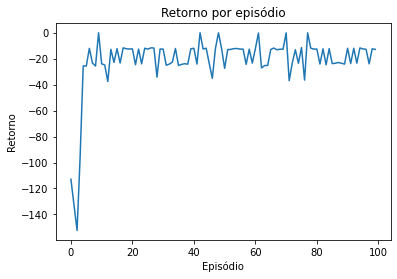

In [16]:
plt.plot(list_retorno)
plt.title('Retorno por episódio')
plt.xlabel('Episódio')
plt.ylabel('Retorno')
plt.show()

## 5. Sugestões <a class="anchor" name="section_5"></a>

Neste momento, faremos algumas sugestões para estender o entendimento do leitor e aprofundar o conhecimento acerca do tema abordado neste notebook, assim como se segue:

1. Altere a estrutura da rede neural e veja quais são as mudanças ocorridas.
2. Altere a técnica de exploração para a utilização do ruído na ação, setando as variáveis para `action_noise==True` e `param_noise==None`. Altere os parâmetros da técnica, se necessário. Tente comparar o desempenho de ambos os métodos.
3. Descomente a construção do ambiente `MountainCarContinuous-v0` presente na célula da Seção 2 em que importamos o ambiente do pêndulo e veja o algoritmo funcionando em um outro problema.
4. Repita o processo de alterar o mecanismo de exploração. É esperado que nesse segundo problema, a técnica de exploração escolhida faça mais diferença do que no primeiro, devido às próprias características do ambiente.
5. Perceba que tanto o agente quanto o crítico são DNNs, mas isso não é uma obrigação. Essas estruturas podem ser substituídas por CNNs, por exemplo, a depender do problema. A biblioteca `gym` oferece diferentes ambientes, dentre os quais vários possuem representação do estado sendo uma imagem, simulando a visão de um agente. [Nesse link](https://gym.openai.com/envs/FetchReach-v0/) há um exemplo de um problema desse tipo, tente implementar um agente que utiliza uma CNN para atuar nesse ambiente (ou em outro de sua preferência).

## 6. Referências <a class="anchor" name="section_6"></a>

- [Deep Deterministic Policy Gradients Explained](https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b)
- Plappert, Matthias. \"Parameter space noise for exploration in deep reinforcement learning.\" arXiv preprint arXiv:1706.01905 (2017). Disponível em: https://matthiasplappert.com/publications/2017_Plappert_Master-thesis.pdf
- [A (Long) Peek into Reinforcement Learning](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html)
- [Policy Gradient Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)